All the information on how to use the Statmorph library can be found at https://statmorph.readthedocs.io/en/latest/

# Import

In [7]:
gain = 3

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import simple_norm
import photutils
import time
import statmorph
import scipy.ndimage as ndi
from astropy.convolution import convolve
from astropy.table import Table
from astropy.table import Column
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import SourceCatalog

from statmorph.utils.image_diagnostics import make_figure

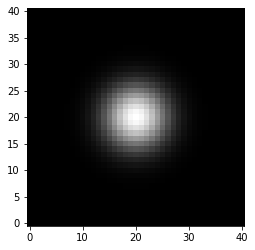

In [9]:
size = 20  # on each side from the center
#sigma_psf = 0.336/0.17 #https://academic.oup.com/pasj/article/70/SP1/S1/4168784
sigma_psf = 4
y, x = np.mgrid[-size:size+1, -size:size+1]
psf = np.exp(-(x**2 + y**2)/(2.0*sigma_psf**2))
psf /= np.sum(psf)

plt.imshow(psf, origin='lower', cmap='gray')
plt.show()

In [10]:
def plot_for_filename(name):
    # Opening fits
    fits_input = fits.open(directory+name)
    data=fits_input[1].data
    
    # Estimating background
    sigma_clip = SigmaClip(sigma=3.)
    bkg_estimator = MedianBackground()
    bkg = Background2D(data, (25,25), filter_size=(3,3),
                    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    
    # Generating segm map
    threshold = photutils.detect_threshold(data-bkg.background, 1.5)
    npixels = 5
    segm = photutils.detect_sources(data-bkg.background, threshold, npixels)
    
    # Grabbing correct object from segm map
    cat = SourceCatalog(data, segm)
    tbl = cat.to_table()
    
    x, y = tbl['xcentroid'], tbl['ycentroid']
    new_tbl = tbl[(x<40.)&(x>20.) & (y>20.)&(y<40.)]
    # If the object isn't centered we manually select it
    if len(new_tbl)==0:
        cmap = segm.make_cmap(seed=123)

        plt.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
        plt.show()
        print(tbl)
        index = int(input("Manually enter index")) - 1
        label = tbl['label'][index]
    else:
        index = np.argmax(new_tbl['area'])
        label = new_tbl['label'][index]
    segmap = segm.data == label

    # Smoothing
    segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
    
    # Trying different smoothings to make sure the object doesn't disappear
    for i in [0.5, 0.4, 0.3, 0.2, 0.1]:
        segmap = segmap_float > i
        if segmap.sum()>15:
            if i!=0.5:
                print(f"Using smoothing {i} for {name}")
            break
        # If final loop has been reached without a good segmap
        if i==0.1:
            print(f"Couldn't make segmentation map for {name}")
            return None
    
    # Statmorph
    source_morphs = statmorph.source_morphology(
        data-bkg.background, segmap.astype(int), gain=gain,
        skybox_size=5,
        #eta=0.3,
        sersic_maxiter=5000,
        #psf=psf
    )

    morph = source_morphs[0]
    fig = make_figure(morph)

## Paths

In [11]:
directory = './downloaded_data/'

In [12]:
from os import listdir
files = listdir(directory)

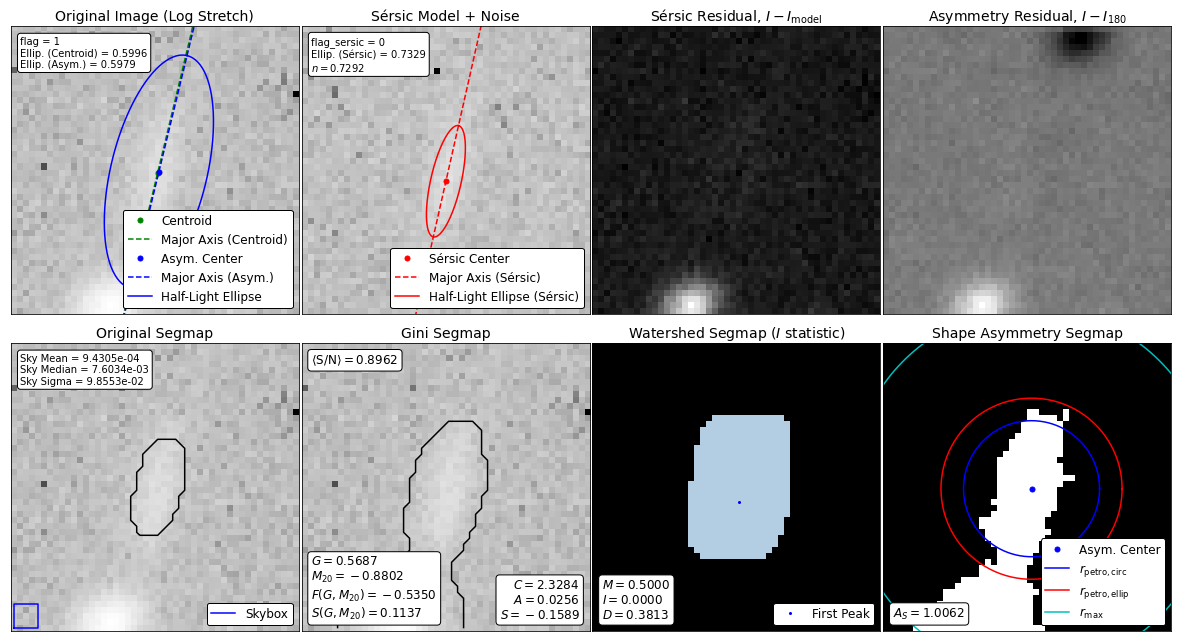

In [34]:
# Bad: 3, 4, 5, 6
# Good: 8, 15
plot_for_filename(files[0])

## Open the image

In [1154]:
files[6]

'ILTJ160002.20+550250.3.fits'

In [1227]:
fits_input = fits.open(directory+files[3])
# 1 is data, 2 is mask, 3 is variance
fits_input.info()
data=fits_input[1].data
hdr=fits_input[1].header

Filename: ./downloaded_data/ILTJ155959.52+545751.0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   ()      
  1                1 ImageHDU        31   (60, 60)   float32   
  2                1 ImageHDU        48   (60, 60)   int32   
  3                1 ImageHDU        31   (60, 60)   float32   


In [1228]:
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(data, (25,25), filter_size=(3,3),
                    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

In [1229]:
print(bkg.background_median) 

0.023184779042822175


In [1230]:
print(bkg.background_rms_median)

0.08682209926447684


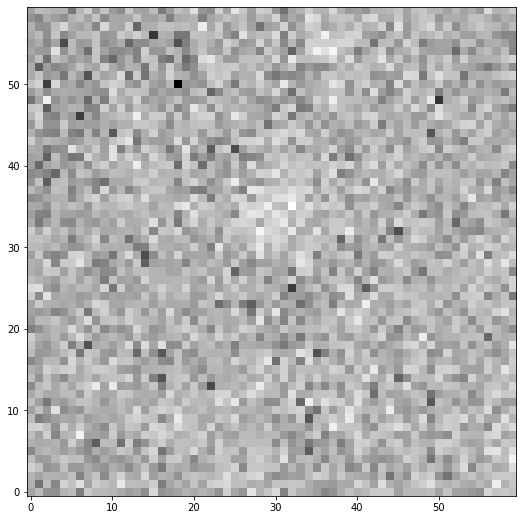

In [1231]:
plt.figure(figsize=(9,9))

plt.imshow(data, cmap='gray', origin='lower',
           norm=simple_norm(data, stretch='sqrt', log_a=1000))

plt.show()

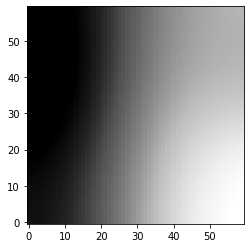

In [1232]:
plt.imshow(bkg.background, origin='lower', cmap='Greys_r',
           interpolation='nearest')

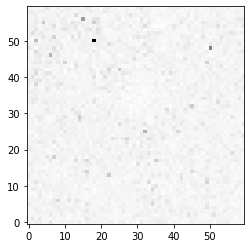

In [1233]:
plt.imshow(data - bkg.background, norm=simple_norm(data, stretch='log', log_a=10000), origin='lower',
            cmap='Greys_r', interpolation='nearest')

In [1234]:
gain = 3

## Create a segmentation map

In [1239]:
threshold = photutils.detect_threshold(data-bkg.background, 1.5)
npixels = 5
segm = photutils.detect_sources(data-bkg.background, threshold, npixels)

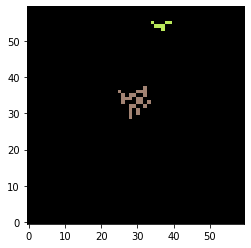

In [1240]:
cmap = segm.make_cmap(seed=123)

plt.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
plt.show()

In [1241]:
cat = SourceCatalog(data, segm)

tbl = cat.to_table()

tbl

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int32,float64,float64,object,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,29.360188300387303,33.47618262191624,None,25,33,29,37,26.0,2.267172194650822,1.894105735275844,41.56536047434326,0.5495686590195827,0.15050947666168213,0.3481840491294861,0.0,5.271246045827866,nan,19.39762573350147,nan
2,36.458271563987445,54.20056388871759,None,34,39,53,55,7.0,1.4671825409717334,0.6284787619043023,3.6924768440887963,0.9036093094379938,0.15202875435352325,0.30890536308288574,0.0,1.437009111046791,nan,5.959987388727003,nan


In [1242]:
x, y = tbl['xcentroid'], tbl['ycentroid']

new_tbl = tbl[(x<40.)&(x>20.) & (y>20.)&(y<40.)]
new_tbl

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int32,float64,float64,object,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,29.360188300387303,33.47618262191624,None,25,33,29,37,26.0,2.267172194650822,1.894105735275844,41.56536047434326,0.5495686590195827,0.15050947666168213,0.3481840491294861,0.0,5.271246045827866,nan,19.39762573350147,nan


In [1243]:
index = np.argmax(new_tbl['area'])

print(new_tbl['label'][np.argmax(new_tbl['area'])])

1


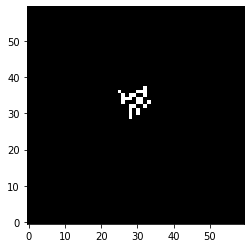

In [1265]:
# Keep only the largest segment
label = new_tbl['label'][index]
segmap = segm.data == label
plt.imshow(segmap, origin='lower', cmap='gray')

plt.show()

In [1249]:
print(segmap.sum())

26


0.26


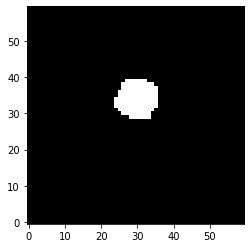

In [1266]:
segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
print(np.max(segmap_float))
segmap = segmap_float > 0.1
plt.imshow(segmap, origin='lower', cmap='gray')

plt.show()

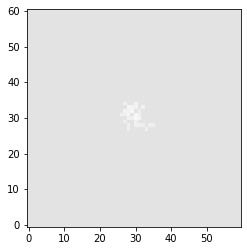

In [1149]:
plt.imshow((data-bkg.background)*segmap, cmap='gray', origin='lower',
           norm=simple_norm(data, stretch='log', log_a=10000))

## Running Statmorph

In [1150]:
start = time.time()
source_morphs = statmorph.source_morphology(
    data-bkg.background, segmap.astype(int), gain=gain,
    psf=psf,
    petro_fraction_gini=1,
    sersic_maxiter=1000)
print('Time: %g s.' % (time.time() - start))

Time: 0.254099 s.


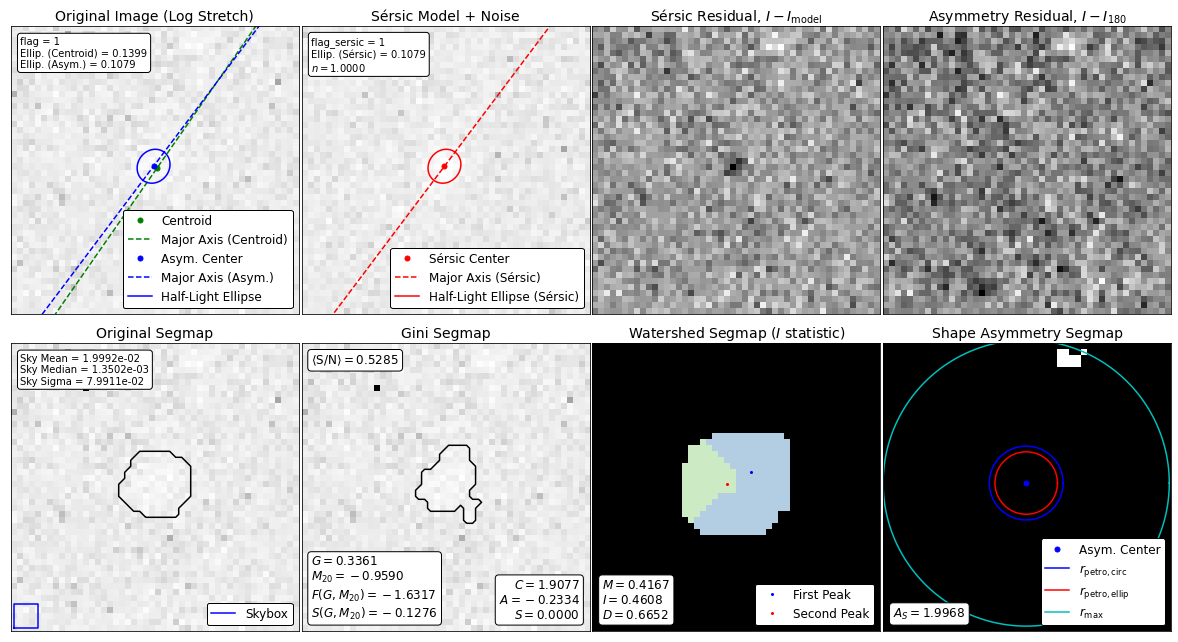

In [1268]:
source_morphs = statmorph.source_morphology(
    data-bkg.background, segmap.astype(int), gain=gain,
    #mask=(fits_input[1].data>0),
    #petro_fraction_gini=0.1,
    #annulus_width=0.1,
    eta=0.3,
    #petro_extent_cas=0.5,
    skybox_size=5,
    sersic_maxiter=5000,
)

morph = source_morphs[0]

from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)

In [309]:
print('xc_centroid =', morph.xc_centroid)
print('yc_centroid =', morph.yc_centroid)
print('ellipticit*y_centroid =', morph.ellipticity_centroid)
print('elongation_centroid =', morph.elongation_centroid)
print('orientation_centroid =', morph.orientation_centroid)
print('xc_asymmetry =', morph.xc_asymmetry)
print('yc_asymmetry =', morph.yc_asymmetry)
print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
print('elongation_asymmetry =', morph.elongation_asymmetry)
print('orientation_asymmetry =', morph.orientation_asymmetry)
print('rpetro_circ =', morph.rpetro_circ)
print('rpetro_ellip =', morph.rpetro_ellip)
print('rhalf_circ =', morph.rhalf_circ)
print('rhalf_ellip =', morph.rhalf_ellip)
print('r20 =', morph.r20)
print('r50 =', morph.r50)
print('r80 =', morph.r80)
print('Gini =', morph.gini)
print('M20 =', morph.m20)
print('F(G, M20) =', morph.gini_m20_bulge)
print('S(G, M20) =', morph.gini_m20_merger)
print('sn_per_pixel =', morph.sn_per_pixel)
print('C =', morph.concentration)
print('A =', morph.asymmetry)
print('S =', morph.smoothness)
print('sersic_amplitude =', morph.sersic_amplitude)
print('sersic_rhalf =', morph.sersic_rhalf)
print('sersic_n =', morph.sersic_n)
print('sersic_xc =', morph.sersic_xc)
print('sersic_yc =', morph.sersic_yc)
print('sersic_ellip =', morph.sersic_ellip)
print('sersic_theta =', morph.sersic_theta)
print('sky_mean =', morph.sky_mean)
print('sky_median =', morph.sky_median)
print('sky_sigma =', morph.sky_sigma)
print('flag =', morph.flag)
print('flag_sersic =', morph.flag_sersic)

xc_centroid = 24.502941861260712
yc_centroid = 28.10706765302751
ellipticity_centroid = 0.4130976312293225
elongation_centroid = 1.7038609029549405
orientation_centroid = -0.19967839379050095
xc_asymmetry = 25.676025369033873
yc_asymmetry = 27.671107032494973
ellipticity_asymmetry = 0.4327399825649363
elongation_asymmetry = 1.762860009985586
orientation_asymmetry = -0.2159664365649049
rpetro_circ = 8.563903601475271
rpetro_ellip = 13.172814130193318
rhalf_circ = 4.606918920590211
rhalf_ellip = 6.04340006859672
r20 = 2.367721497778946
r50 = 4.263994872512453
r80 = 7.25274061415324
Gini = 0.571387041872976
M20 = -1.616981464847623
F(G, M20) = -0.011065987589366166
S(G, M20) = 0.013912747840426565
sn_per_pixel = 1.339176414051641
C = 2.4308576417396472
A = 0.18981836399699617
S = 0.05136741712553751
sersic_amplitude = 3.378101983819128
sersic_rhalf = 4.891090860100572
sersic_n = 2.1206227629627366
sersic_xc = 24.983192262169226
sersic_yc = 28.99998766464263
sersic_ellip = 0.93597945870240

In [77]:
segmap.astype(int)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

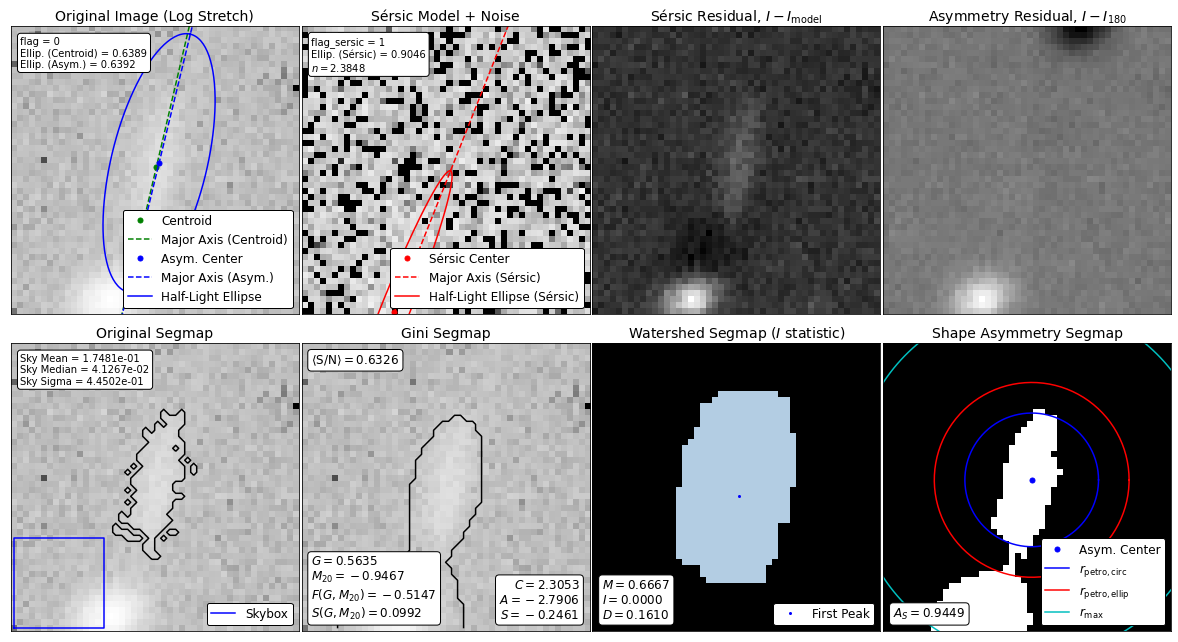

### Run Statmorph on a batch of images and save the parameters in a table

In [ ]:
for name in file_names:
    
    start = time.time()
    
    try:
        fits_input = fits.open(directory+name)
        fits_input.info()
        data=fits_input[0].data
        hdr=fits_input[0].header

        data = sub_background(data, show_plots=True)

    
        segmap = segmentation_map(data, show_plots=True)
        
#     except:
#         print('I skip this galaxy: ', name, '\n')
#         continue
    
#     try:
        source_morphs = statmorph.source_morphology(
            data, segmap, gain=gain,psf=psf)


        morph = source_morphs[0]
        new_row = [name, morph.xc_centroid, morph.yc_centroid, morph.ellipticity_centroid, morph.elongation_centroid,
               morph.orientation_centroid, morph.xc_asymmetry, morph.yc_asymmetry, morph.ellipticity_asymmetry, 
               morph.elongation_asymmetry, morph.orientation_asymmetry, morph.r20,morph.r50,morph.r80,
               morph.rhalf_circ, morph.rhalf_ellip, morph.rmax_circ, morph.rmax_ellip, morph.rpetro_circ,
               morph.rpetro_ellip, morph.concentration, morph.asymmetry, morph.smoothness, morph.m20, morph.gini,
               morph.gini_m20_bulge, morph.gini_m20_merger, morph.deviation, morph.shape_asymmetry, 
               morph.outer_asymmetry, morph.multimode, morph.sn_per_pixel, morph.flux_circ, morph.flux_ellip,
               morph.intensity, morph.sersic_xc, morph.sersic_yc, morph.sersic_amplitude, morph.sersic_ellip,
               morph.sersic_n, morph.sersic_rhalf, morph.sersic_theta, morph.sky_mean, morph.sky_median, 
               morph.sky_sigma, morph.nx_stamp, morph.ny_stamp, morph.xmax_stamp, morph.xmin_stamp,
               morph.ymax_stamp, morph.ymin_stamp, morph.flag, morph.flag_sersic
              ]

        table.add_row(new_row)
        
    except:
        print('I skip this galaxy: ',name,'\n')
        continue

    print('Time: %g s.' % (time.time() - start))

## Various

In [114]:
morph.asymmetry
morph.concentration
morph.deviation
morph.ellipticity_asymmetry
morph.ellipticity_centroid
morph.elongation_asymmetry
morph.elongation_centroid
morph.flux_circ
morph.flux_ellip
morph.gini
morph.gini_m20_bulge
morph.gini_m20_merger
morph.intensity
morph.m20
morph.multimode
morph.nx_stamp
morph.ny_stamp
morph.orientation_asymmetry
morph.orientation_centroid
morph.outer_asymmetry
morph.r20
morph.r50
morph.r80
morph.rhalf_circ
morph.rhalf_ellip
morph.rmax_circ
morph.rmax_ellip
morph.rpetro_circ
morph.rpetro_ellip
morph.sersic_amplitude
morph.sersic_ellip
morph.sersic_n
morph.sersic_rhalf
morph.sersic_theta
morph.sersic_xc
morph.sersic_yc
morph.shape_asymmetry
morph.sky_mean
morph.sky_median
morph.sky_sigma
morph.smoothness
morph.sn_per_pixel
morph.xc_asymmetry
morph.xc_centroid
morph.xmax_stamp
morph.xmin_stamp
morph.yc_asymmetry
morph.yc_centroid
morph.ymax_stamp
morph.ymin_stamp
morph.flag
morph.flag_sersic

0

In [156]:
col_names = ('ID','xc_centroid','yc_centroid', 'ellipticity_centroid', 'elongation_centroid', 'orientation_centroid',
         'xc_asymmetry', 'yc_asymmetry','ellipticity_asymmetry', 'elongation_asymmetry', 'orientation_asymmetry',
         'r20','r50','r80','rhalf_circ','rhalf_ellip','rmax_circ','rmax_ellip','rpetro_circ','rpetro_ellip',
         'C','A','S','M20','Gini', 'F(G,M20)', 'S(G,M20)', 'deviation', 'shape_asymmetry','outer_asymmetry',
         'multimode','sn_per_pixel','flux_circ','flux_ellip','intensity',
         'sersic_xc','sersic_yc','sersic_amplitude', 'sersic_ellip','sersic_n','sersic_rhalf','sersic_theta',
         'sky_mean','sky_median','sky_sigma',
         'nx_stamp','ny_stamp','xmax_stamp','xmin_stamp','ymax_stamp','ymin_stamp',
        'flag', 'flag_sersic'
        )

t = Table(names=col_names)
t['ID'] = Column(name='ID', dtype='str')

In [151]:
a = ['name_code', morph.xc_centroid,morph.yc_centroid,morph.deviation,
morph.ellipticity_asymmetry,
morph.ellipticity_centroid,
morph.elongation_asymmetry,
morph.elongation_centroid,
morph.flux_circ,
morph.flux_ellip,
morph.gini,
morph.gini_m20_bulge,
morph.gini_m20_merger,
morph.intensity,
morph.m20,
morph.multimode,
morph.nx_stamp,
morph.ny_stamp,
morph.orientation_asymmetry,
morph.orientation_centroid,
morph.outer_asymmetry,
morph.r20,
morph.r50,
morph.r80,
morph.rhalf_circ,
morph.rhalf_ellip,
morph.rmax_circ,
morph.rmax_ellip,
morph.rpetro_circ,
morph.rpetro_ellip,
morph.sersic_amplitude,
morph.sersic_ellip,
morph.sersic_n,
morph.sersic_rhalf,
morph.sersic_theta,
morph.sersic_xc,
morph.sersic_yc,
morph.shape_asymmetry,
morph.sky_mean,
morph.sky_median,
morph.sky_sigma,
morph.smoothness,
morph.sn_per_pixel,
morph.xc_asymmetry,
morph.xc_centroid,
morph.xmax_stamp,
morph.xmin_stamp,
morph.yc_asymmetry,
morph.yc_centroid,
morph.ymax_stamp,
morph.ymin_stamp,
morph.flag,
morph.flag_sersic
    ]

# a.append('name_code')

# a.append(morph.xc_centroid,morph.yc_centroid)

a

['name_code',
 157.3893317511049,
 121.30740903884127,
 0.32029018213477545,
 0.1551522591067741,
 0.19160695427797958,
 1.1836452316753991,
 1.2370220220126273,
 8666.128848703593,
 8666.128848703594,
 0.54317602576636,
 -0.21027314712434508,
 -0.0020692525593728472,
 0.7328667869206796,
 -1.5310325040868293,
 1.0,
 194,
 194,
 -0.4177011168256745,
 -0.6953135854787489,
 0.38249759950306866,
 22.131080130431307,
 42.41955241051065,
 80.0897508882391,
 42.055457867630196,
 44.48019568045921,
 125.57571534926569,
 128.42783250271876,
 107.3520195931731,
 114.14304095614362,
 0.05159898604980519,
 0.44220208305721925,
 1.4317296809509419,
 178.64349385085103,
 2.439791162379436,
 152.59608044563475,
 115.70192792942363,
 0.5066768961049111,
 0.08068444,
 0.08056289,
 0.027078442,
 -0.046394609113095765,
 0.63315296,
 147.23718668178114,
 157.3893317511049,
 238,
 45,
 117.78347771345625,
 121.30740903884127,
 224,
 31,
 1,
 0]

In [159]:
t

ID,xc_centroid,yc_centroid,ellipticity_centroid,elongation_centroid,orientation_centroid,xc_asymmetry,yc_asymmetry,ellipticity_asymmetry,elongation_asymmetry,orientation_asymmetry,r20,r50,r80,rhalf_circ,rhalf_ellip,rmax_circ,rmax_ellip,rpetro_circ,rpetro_ellip,C,A,S,M20,Gini,"F(G,M20)","S(G,M20)",deviation,shape_asymmetry,outer_asymmetry,multimode,sn_per_pixel,flux_circ,flux_ellip,intensity,sersic_xc,sersic_yc,sersic_amplitude,sersic_ellip,sersic_n,sersic_rhalf,sersic_theta,sky_mean,sky_median,sky_sigma,nx_stamp,ny_stamp,xmax_stamp,xmin_stamp,ymax_stamp,ymin_stamp,flag,flag_sersic
str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
name_code,157.3893317511049,121.30740903884127,0.32029018213477545,0.1551522591067741,0.19160695427797958,1.1836452316753991,1.2370220220126273,8666.128848703593,8666.128848703594,0.54317602576636,-0.21027314712434508,-0.0020692525593728472,0.7328667869206796,-1.5310325040868293,1.0,194.0,194.0,-0.4177011168256745,-0.6953135854787489,0.38249759950306866,22.131080130431307,42.41955241051065,80.0897508882391,42.055457867630196,44.48019568045921,125.57571534926569,128.42783250271876,107.3520195931731,114.14304095614362,0.05159898604980519,0.44220208305721925,1.4317296809509419,178.64349385085103,2.439791162379436,152.59608044563475,115.70192792942363,0.5066768961049111,0.08068443834781647,0.08056288957595825,0.02707844227552414,-0.046394609113095765,0.633152961730957,147.23718668178114,157.3893317511049,238.0,45.0,117.78347771345625,121.30740903884127,224.0,31.0,1.0,0.0
